[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github//IIS-KI-Tutorials/KI-Tutorials/blob/main/active-learning/3_Regression_mit_modAL.ipynb)

# Regression mit modAL
Im Gegesatz zur Klassifikation ist es bei der Regression nicht ganz so einfach, ein gutes Maß für die Unsicherheit gegenüber einem neuen Datenpunkt zu bestimmen. Eine häufig angewandte Möglichkeit ist es, anstelle von nur einem Modell, ein ganzes Ensemble an verschiedenen Modellen zu trainieren und dann Datenpunkte zu wählen, bei denen sich die Modelle am stärksten gegenseitig widersprechen. Konkret verwenden wir hierbei die maximale Standardabweichung der Vorhersagen der verschiedenen Modelle als Kriterium, um die Unsicherheit zu quantifizieren. Die Standardabweichung ergibt sich aus den unterschiedlichen Vorhersagen, die jedes Modell für einen bestimmten Datenpunkt liefert. Indem wir die maximale Standardabweichung wählen, identifizieren wir diejenigen Datenpunkte, bei denen die Modelle die größten Abweichungen voneinander aufweisen und somit die Unsicherheit am größten ist.


## Inhaltsverzeichnis
1. [Imports](#Imports)
2. [Erzeugen der Daten](#Erzeugen-der-Daten)
3. [Initialisierung des Ensembles](#Initialisierung-des-Ensembles)
4. [Umsetzung des Active Learning Cycles](#Umsetzung-des-Active-Learning-Cycles)
5. [Evaluation: Vergleich mit zufälliger Auswahlstrategie](#Evaluation:-Vergleich-mit-zufälliger-Auswahlstrategie)


## 1. Imports <a id='Imports'></a>

Die Bibliotheken `pandas` und `numpy` werden verwendet, um Daten zu laden und zu verarbeiten. `matplotlib` und `seaborn` werden verwendet, um Visualisierungen zu erstellen. Aus `sklearn` verwenden wir verschiedene Regressionsalgorithmen und Metriken.
Alle Active Learning spezifische Funktionen erhalten wir aus dem Modul `modAL`. 
Wir importieren dazu die Klassen `ActiveLearner` und `CommitteeRegressor` aus `modAL.models`. Die Klasse `ActiveLearner` ist die Basisklasse für alle Active Learning Modelle in modAL. Die Klasse `CommitteeRegressor` stellt die erforderlichen Funktionen für Active Learning Regression mit Ensembles zur Verfügung.

Für unser Auswahlkriterium `max_std_sampling` importieren wir die entsprechende Funktion aus dem Modul `modAL.disagreement`.

In [1]:
#Grundlegende Imports
from itertools import cycle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

#Active learning spezifische Imports
from modAL.models import ActiveLearner, CommitteeRegressor
from modAL.disagreement import max_std_sampling

#Regressions Modelle
from sklearn.linear_model import LinearRegression, Ridge, Lasso, PoissonRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

#Metriken
from sklearn.metrics import mean_absolute_error, mean_squared_error

## 2. Erzeugen der Daten <a id='Erzeugen-der-Daten'></a>

Für dieses Beispiel verwenden wir syntetische Daten welche wir mit Hilfe der Funktion `make_regression` von `sklearn.datasets` erzeugen.

In [2]:
X, y = make_regression(n_samples=1000,
                       n_features=3,
                       n_informative=2,
                       random_state=42,
                       noise=2
                      )
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=42, shuffle=True)

### 3. Initialisierung des Ensembles <a id="Initialisierung-des-Ensembles"></a>

Zunächst muss das Ensemble initialisiert werden, dazu mussen folgende Kriterien festgelegt werden:
- **Anzahl der Modelle:** Es ist ratsam, die Ensemble-Gruppe aus einer Vielzahl von Modellen zusammenzustellen. Die Stärken eines Ensembles treten besonders hervor, wenn die enthaltenen Modelle eine facettenreiche Vielfalt aufweisen und somit Abweichungen in den Vorhersagen präsentieren. Diese Diversität innerhalb der Modelle kann auf unterschiedliche Weisen erzielt werden. Es besteht die Möglichkeit, jedem Modell verschiedene Trainingsdaten zuzuweisen, unterschiedliche Algorithmen einzusetzen oder auf das Prinzip des Bootstrappings zurückzugreifen. Beim Bootstrapping wird für jede Trainingsrunde eine spezifische Untergruppe aus den verfügbaren Trainingsdaten zufällig ausgewählt, die in diesem Schritt genutzt wird. In der vorliegenden Situation kombinieren wir sowohl das Bootstrapping-Prinzip als auch den Einsatz verschiedener Algorithmen, um die Variabilität unserer Ensemble-Modelle zu maximieren.
- **Initiale Trainingsdaten:** Die Entscheidung über die Menge an initial gelabelten Datenpunkten erfordert eine sorgfältige Abwägung. Eine zu knappe Auswahl könnte dazu führen, dass diese wenigen Datenpunkte zufällig ungünstig gewählt sind und dadurch die ersten Modelle in unerwünschter Weise beeinflussen. Es ist jedoch ebenso wichtig, eine übermäßige Vorlabelung von Datenpunkten zu vermeiden, da dies ineffizient wäre. Das Ziel besteht darin, eine ausgewogene Menge an initialen Datenpunkten zu wählen, um das Ensemble solide zu initialisieren.
- **Auswahlkriterium:** Bei Regressionsaufgaben hat sich üblicherweise bewährt, den Datenpunkt aus dem Datenpool zu wählen, der die höchste Standardabweichung zwischen den Vorhersagen der einzelnen Modelle aufweist. Auf diese Weise wird derjenige Datenpunkt ausgewählt, der die größte Diskrepanz bzw. Uneinigkeit zwischen den Modellen zeigt.
<br/><br/>
Für diese Aufgabe stellt ModAL die Klasse `CommitteeRegressor` bereit. Diese umfasst eine Liste von `ActiveLearner` und eine `query_strategy`.  Jede Instanz von `ActiveLearner` umfasst wiederum einen Sklearn kompatiblen Estimator und die initialen Trainingsdaten für das jeweilige Model. ([siehe Dokumentation](https://modal-python.readthedocs.io/en/latest/content/apireference/models.html))

In [3]:
X_pool, y_pool = X_dev.copy(), y_dev.copy()

# Liste an Regressionsalgorithmen, die wir in unserem Ensemble verwenden wollen
regression_algo_list = [LinearRegression, Ridge, Lasso, DecisionTreeRegressor, GaussianProcessRegressor] 

init_train_size = 20 # Menge an initialen Trainingsdaten, die wir zufällig auswählen und labeln
init_idx = np.random.choice(range(X_pool.shape[0]), size=init_train_size, replace=False)
# Erstellt eine Liste von ActiveLearner-Objekten, die wir in unserem Ensemble verwenden wollen.
learner_list = [
    ActiveLearner(
        # Regressions-Algorithmus
        estimator=Regressor(random_state=42) if hasattr(Regressor.__init__, 'random_state') else Regressor(),
        X_training=X_pool[init_idx],
        y_training=y_pool[init_idx], # Zielwert der Trainingsdaten
        bootstrap_init=True, # Nutze Bootstraping um zusätzliche Variation zwischen den Modellen zu erzeugen
    )
    for Regressor in regression_algo_list
    ]

#Entfernt die initialen Trainingsdaten aus dem Datenpool, damit diese nicht doppelt ausgewählt werden.
X_pool = np.delete(X_pool, init_idx, axis=0)
y_pool = np.delete(y_pool, init_idx)

# Committee ist hier das selbe wie ein Ensemble.
ensemble = CommitteeRegressor(
    learner_list=learner_list, #Vorab definierte Liste an Modellen
    query_strategy=max_std_sampling # Strategie zur Bestimmung der Label-Reihenfolge
)

### 4. Umsetzung des Active Learning Cycles <a id="Umsetzung-des-Active-Learning-Cycles"></a>
Um später die Genauigkeit der Modelle im Vergleich zur zufälligen Auswahl der Datenpunkte zu bewerten, speichern wir in jeder Iteration den durchschnittlichen absoluten Fehler (MAE) des aktuellen Ensembles auf den Testdaten.

In [4]:
performance = [mean_absolute_error(y_test, ensemble.predict(X_test))] # Liste zum Speichern der Genauigkeit (MAE) der Modelle auf den Testdaten
n_queries = 50 #Legt die Anzahl der Iterationen fest
samples_per_iter = 4

Nach der erfolgreichen Initialisierung des Ensembles setzen wir den Active Learning Zyklus in Gang. Hierbei bedienen wir uns einer FOR-Schleife, bei der im Vorfeld die gewünschte Anzahl der Iterationen festgelegt wird. Eine alternative Option besteht darin, eine WHILE-Schleife zu verwenden, welche in jedem Durchlauf überprüft, ob bestimmte Zielkriterien erfüllt sind.

Es gibt keine zwingende Einschränkung, in jeder Iteration lediglich nur einen einzelnen Datenpunkt auszuwählen. Unser vorrangiges Ziel besteht darin, den Aufwand für die Modellentwicklung (Training) und den Aufwand für das Labeln der Daten zu minimieren. Da das Training in diesem konkreten Beispiel auch recht viel Zeit beansprucht, werden gemäß unserem Auswahlkriterium in jeder Iteration `samples_per_iter` neue Datenpunkte ausgewählt, gelabelt und in die Trainingsdaten integriert.

In [5]:
#Active Learning Cycle
for idx in range(1, n_queries+1):
    print(f"Query no. {idx} of {n_queries}", end="\r")
    
    # Query the unlabeled points, select the five most uncertain
    query_idxs, query_instances = ensemble.query(X_pool, n_instances=samples_per_iter) # Bestimmt die nächsten 5 Datenpunkte durch das Committee
    
    # Fügt die neuen Datenpunkte + Labels zu den Trainingsdaten hinzu und trainiert die Modelle erneut. 
    ensemble.teach(
        X=X_pool[query_idxs],
        y=y_pool[query_idxs],
    )
    
    # Evaluieret die aktuelle Genauigkeit auf den Testdaten
    performance.append(mean_absolute_error(y_test, ensemble.predict(X_test))) 
    
    #Entfernt die gelabelten Trainingsdaten aus dem Datenpool
    X_pool = np.delete(X_pool, query_idxs, axis=0)
    y_pool = np.delete(y_pool, query_idxs)
X_pool_left_max_sampling = X_pool.copy()

### 5. Evaluation: Vergleich mit zufälliger Auswahlstrategie <a id="Evaluation:-Vergleich-mit-zufälliger-Auswahlstrategie"></a>

Um beurteilen zu können wie gut die gewählte Stretegie ist, führen wir das selbe Experiment erneut durch, nur diesmal wählen wir in jedem Schritt zufällige Datenpunkte.

Dazu definieren wir uns zunächst unsere eigene Querry-Strategie. Diese permutiert die übrigen Daten im Pool in eine beliebige Reihenfolge und gibt dann die ersten `n_instances` zurück.

In [6]:
def random_sampling(comittee, X, n_instances=1):
    idxs = np.random.permutation(X.shape[0])[:n_instances]
    return idxs, X[idxs]

Um sicherzugehen, dass wir die selbe Ausgangssituation wie im obigen Experiment haben initialisieren wir den Datenpool erneut.

In [7]:
X_pool, y_pool = X_dev.copy(), y_dev.copy()

Wir initialiseren erneut ein CommitteeRegressor, nur diesmal mit der von uns definierten Strategie `random_sampling` als `query_strategy`.

In [8]:
# Erstellt eine Liste von ActiveLearner-Objekten, die wir in unserem Ensemble verwenden wollen.
learner_list = [
    ActiveLearner(
        estimator=Regressor(random_state=42) if hasattr(Regressor.__init__, 'random_state') else Regressor(),
        X_training=X_pool[init_idx],
        y_training=y_pool[init_idx], # Zielwert der Trainingsdaten
        bootstrap_init=False, # Nutze Bootstraping um zusätzliche Variation zwischen den Modellen zu erzeugen
    )
    for Regressor in regression_algo_list
    ]

#Entfernt die initialen Trainingsdaten aus dem Datenpool, damit diese nicht doppelt ausgewählt werden.
X_pool = np.delete(X_pool, init_idx, axis=0)
y_pool = np.delete(y_pool, init_idx)

# Erzeugt ein CommitteeRegressor Objekt, das die ActiveLearner Objekte enthält.
ensemble_random = CommitteeRegressor(
    learner_list=learner_list,
    query_strategy=random_sampling # Legt als Auswahlkriterium die von uns definierte Funktion fest.
)

Wir durchlaufen den selben Active Learning Cycle und evaluieren erneut in jeder Iteration das aktuelle Ensemble und speichern dessen MAE.

In [9]:
performance_random = [mean_absolute_error(y_test, ensemble_random.predict(X_test))]

np.random.seed(42)
for idx in range(1, n_queries+1):
    print(f"Query no. {idx} of {n_queries}", end="\r")
    # Query the unlabeled points, select the five most uncertain
    query_idxs, query_instances = ensemble_random.query(X_pool, n_instances=samples_per_iter) # Bestimmt die nächsten 5 Datenpunkte durch das Committee
    ensemble_random.teach(
        X=X_pool[query_idxs],
        y=y_pool[query_idxs]
    )
    performance_random.append(mean_absolute_error(y_test, ensemble_random.predict(X_test)))
    X_pool = np.delete(X_pool, query_idxs, axis=0)
    y_pool = np.delete(y_pool, query_idxs)
X_pool_left_random = X_pool.copy()

Zum Vergleich plotten wir die Genauigkeit der beiden finalen Ensembles.

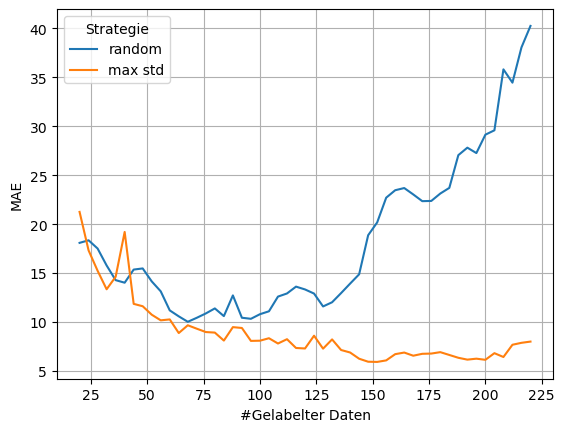

In [10]:
# plot the results
plt.plot(np.arange(init_train_size, samples_per_iter*n_queries+init_train_size+1, samples_per_iter), performance_random, label='random')
plt.plot(np.arange(init_train_size, samples_per_iter*n_queries+init_train_size+1, samples_per_iter), performance, label='max std')
plt.ylabel('MAE')
plt.xlabel('#Gelabelter Daten')
plt.legend(title="Strategie")
plt.grid()
plt.show()

Je nach verwendetetem `random_state` kann es zu unterschiedlichen Ergebnissen kommen. Allerdings lässt sich im Allgemeinen feststellen, dass die Auswahl der Datenpunkte auf Basis der größten Standardabweichung in den Modellvorhersagen einen positiven Einfluss auf die Genauigkeit des Ensembles hat. Das Modell konvergiert schneller und interessanterweise tritt Overfitting erst deutlich später im Vergleich zur zufälligen Auswahl der Datenpunkte auf. Es ist jedoch wichtig zu beachten, dass dieses Verhalten nicht bei allen untersuchten Datensätzen festgestellt wurde, sodass diese Strategie nicht immer empfohlen werden kann. Um Active Learning effektiv einzusetzen, ist es wichtig, geeignete Modelle auszuwählen, einen angemessenen initialen Trainingsdatensatz zu verwenden und eine passende Sampling-Strategie zu wählen.